In [1]:
import cv2
from PIL import Image
import numpy as np 
# import pandas as pd
import os 
# import tensorflow as tf
# from keras.models import Sequential
# from keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import keras_cv
from collections import Counter

c:\Users\PC\anaconda3\envs\messi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Getting Images**

In [2]:
polen_dosya_adresi = "C:\\Users\\PC\\OneDrive\\Masaüstü\\polen-github\\pollen_data\\pollen\\"
siniflar_listesi = os.listdir(polen_dosya_adresi)
print("Total number of classes is {}".format(len(siniflar_listesi)))

Total number of classes is 268


In [3]:
'''
İleride kullanilabilecek bilgilerin alinmasi
'''

fotograf_sirasiyla_etiketi_listesi = []   
sinif_adresi_sozlugu  = {}                
foto_adresi_listesi = []                  

for dosya_adi in siniflar_listesi:
  adres_listesi = [] 
  adres = polen_dosya_adresi + dosya_adi + "\\"

  for foto_adi in os.listdir(adres):
    fotograf_sirasiyla_etiketi_listesi.append(dosya_adi)
    fotograf_adresi = adres + foto_adi
    adres_listesi.append(fotograf_adresi)
    foto_adresi_listesi.append(fotograf_adresi)

  sinif_adresi_sozlugu[dosya_adi] = adres_listesi

all_images = Counter(fotograf_sirasiyla_etiketi_listesi)


In [4]:
'''
Degiskenlerin neyi tuttugunun gorseli
'''

print("fotograf_sirasiyla_etiketi_listesi: ", fotograf_sirasiyla_etiketi_listesi[:10])
print("fotograf_sirasiyla_etiketi_listesi: ", len(fotograf_sirasiyla_etiketi_listesi))
print("sinif_adresi_sozlugu: ", sinif_adresi_sozlugu)
print("sinif_adresi_sozlugu: ", len(sinif_adresi_sozlugu))
print("foto_adresi_listesi: ", foto_adresi_listesi[:10])
print("foto_adresi_listesi: ", len(foto_adresi_listesi))
print("all_images: ", list(all_images)[:10])
print("all_images: ", len(all_images))
print("all_images: ", sum(list(all_images.values())))

fotograf_sirasiyla_etiketi_listesi:  ['Acantholimon acerosum', 'Acantholimon acerosum', 'Acantholimon acerosum', 'Acantholimon acerosum', 'Acantholimon armenum', 'Acantholimon armenum', 'Acantholimon armenum', 'Acantholimon armenum', 'Acantholimon calvertii', 'Acantholimon calvertii']
fotograf_sirasiyla_etiketi_listesi:  1775
sinif_adresi_sozlugu:  {'Acantholimon acerosum': ['C:\\Users\\PC\\OneDrive\\Masaüstü\\polen-github\\pollen_data\\pollen\\Acantholimon acerosum\\Acantholimon acerosum11 100x.jpg', 'C:\\Users\\PC\\OneDrive\\Masaüstü\\polen-github\\pollen_data\\pollen\\Acantholimon acerosum\\Acantholimon acerosum12 100x.jpg', 'C:\\Users\\PC\\OneDrive\\Masaüstü\\polen-github\\pollen_data\\pollen\\Acantholimon acerosum\\Acantholimon acerosum13 100x.jpg', 'C:\\Users\\PC\\OneDrive\\Masaüstü\\polen-github\\pollen_data\\pollen\\Acantholimon acerosum\\Acantholimon acerosum14 100x.jpg'], 'Acantholimon armenum': ['C:\\Users\\PC\\OneDrive\\Masaüstü\\polen-github\\pollen_data\\pollen\\Acantholi

# **Verileri Bölme**

In [5]:
foto_boyutu = 128

def process_img(img, size = (foto_boyutu,foto_boyutu)):
    img = cv2.resize(img, size)  
    img = img/255                   
    return img

# def scale_uygula(img):
#     img = img/255                   
#     return img

# def boyut_ayarla(img, size = (foto_boyutu,foto_boyutu)):
#     img = cv2.resize(img, size)
#     return img



In [6]:
import math

# TODO: Familya etiketi eklenicek y_ler eklenirken o yenin karsiligi olan familya etiketi bilgisi eklenicek

'''
Her klasore gidiliyor
her klasorun fotograf sayisina gore train test validation eleman sayisi belirleniyor rastgele secim yapilarak ayriliyor
'''
seed_degeri = 30
random.seed(seed_degeri)

train_orani = 0.75 

x_train              = []
x_val                = []
x_test               = []
y_train              = []
y_val                = []
y_test               = []

y_familya_train      = []
y_familya_val        = []
y_familya_test       = []


klasor_sayisi = len(os.listdir(polen_dosya_adresi))
for sayac, polen_sinifi in enumerate(os.listdir(polen_dosya_adresi)):
    
    # Progres Bar Gosterimi
    if sayac % 20 == 0 or sayac == klasor_sayisi - 1:
      print((sayac + 1), " / ", klasor_sayisi, "\tprogress: %", 100 * (sayac + 1)/klasor_sayisi)
    
    polen_sinifinin_adresi   = os.path.join(polen_dosya_adresi, polen_sinifi) # Polen sinifini klasorunun adresi
    eleman_sayisi            = len(os.listdir(polen_sinifinin_adresi))       # Polen sinifinin eleman sayisi
    sinifa_ait_fotograflar   = os.listdir(polen_sinifinin_adresi)            # Polen sinifina ait fotolarin adi

    # 3 ise 1-1-1 veya 4 ise 2-1-1 bol   belirtilmezse  2-1-0 ve 3-1 boler
    if eleman_sayisi > 4:
        train_icin_eleman_sayisi = math.floor(eleman_sayisi * train_orani) 
        test_icin_eleman_sayisi = (eleman_sayisi - train_icin_eleman_sayisi) // 2
        val_icin_eleman_sayisi = eleman_sayisi - train_icin_eleman_sayisi - test_icin_eleman_sayisi

    elif eleman_sayisi > 3:
        train_icin_eleman_sayisi = 2
        val_icin_eleman_sayisi   = 1
        test_icin_eleman_sayisi  = 1
    
    else:
        train_icin_eleman_sayisi = 1
        val_icin_eleman_sayisi   = 1
        test_icin_eleman_sayisi  = 1
    
    #print(f"woaoaoaoa {train_icin_eleman_sayisi}")

    # eleman sayisi 0 ise herhangi bir eleman setinin bir sorun vardır (Olmamalı) 
    if train_icin_eleman_sayisi == 0 or train_icin_eleman_sayisi == 0 or train_icin_eleman_sayisi == 0:
        raise Exception("0 ELEMAN")
    
    # Trainden train eleman sayisi kadar al, valden val sayisi kadar al ama traindekilerden alma, aynı şekilde kalanini teste koy
    train_elemanlari = random.sample(sinifa_ait_fotograflar, train_icin_eleman_sayisi)
    val_elemanlari   = random.sample(list(set(sinifa_ait_fotograflar) - set(train_elemanlari)), val_icin_eleman_sayisi)
    test_elemanlari  = random.sample(list(set(sinifa_ait_fotograflar) - set(train_elemanlari) - set(val_elemanlari)), test_icin_eleman_sayisi)
  
    
    for train_elemani in train_elemanlari:
        train_elemaninin_adresi = os.path.join(polen_sinifinin_adresi, train_elemani)
        img = mpimg.imread(train_elemaninin_adresi)
        x_train.append(img)
        y_train.append(polen_sinifi)
                
    for val_elemani in val_elemanlari:
        val_elemaninin_adresi = os.path.join(polen_sinifinin_adresi, val_elemani)
        img = mpimg.imread(val_elemaninin_adresi)
        # x_val.append(img)
        x_val.append(process_img(img))
        y_val.append(polen_sinifi)
        
    for test_elemani in test_elemanlari:
        test_elemaninin_adresi = os.path.join(polen_sinifinin_adresi, test_elemani)
        img = mpimg.imread(test_elemaninin_adresi)
        # x_test.append(img)
        x_test.append(process_img(img))
        y_test.append(polen_sinifi)   


1  /  268 	progress: % 0.373134328358209
21  /  268 	progress: % 7.835820895522388
41  /  268 	progress: % 15.298507462686567
61  /  268 	progress: % 22.761194029850746
81  /  268 	progress: % 30.223880597014926
101  /  268 	progress: % 37.6865671641791
121  /  268 	progress: % 45.149253731343286
141  /  268 	progress: % 52.61194029850746
161  /  268 	progress: % 60.07462686567164
181  /  268 	progress: % 67.53731343283582
201  /  268 	progress: % 75.0
221  /  268 	progress: % 82.46268656716418
241  /  268 	progress: % 89.92537313432835
261  /  268 	progress: % 97.38805970149254
268  /  268 	progress: % 100.0


In [7]:
print(f"x_train eleman sayisi : {len(x_train)}")
print(f"x_val   eleman sayisi : {len(x_val)}")
print(f"x_test  eleman sayisi : {len(x_test)}")
print(f"y_train eleman sayisi : {len(y_train)}")
print(f"y_val   eleman sayisi : {len(y_val)}")
print(f"y_test  eleman sayisi : {len(y_test)}")
print( len(x_train) + len(x_val) + len(x_test) )
print( len(y_train) + len(y_val) + len(y_test) )
print("oranlari train : ", len(x_train) / (len(x_train) + len(x_val) + len(x_test)))
print("oranlari test : ", len(x_test) / (len(x_train) + len(x_val) + len(x_test)))
print("oranlari val : ", len(x_val) / (len(x_train) + len(x_val) + len(x_test)))

x_train eleman sayisi : 1096
x_val   eleman sayisi : 351
x_test  eleman sayisi : 328
y_train eleman sayisi : 1096
y_val   eleman sayisi : 351
y_test  eleman sayisi : 328
1775
1775
oranlari train :  0.6174647887323944
oranlari test :  0.1847887323943662
oranlari val :  0.19774647887323943


In [8]:
for i, (train_elemani_etiketi, train_elemani) in enumerate(zip(y_train, x_train)):
    print(train_elemani[0][0][0])

198
220
208
216
214
217
197
187
198
181
185
183
190
190
196
192
218
204
213
213
209
206
207
206
198
208
200
205
228
226
212
219
204
216
217
205
208
206
193
195
195
191
203
205
198
207
221
192
206
184
200
216
205
183
221
178
200
205
203
196
186
216
213
218
202
200
195
195
196
190
200
202
199
172
203
198
202
216
194
210
188
194
205
204
200
197
204
200
206
201
200
200
195
196
206
149
198
210
188
201
199
194
204
195
198
215
211
197
207
195
200
199
203
206
210
209
217
222
209
214
208
196
204
212
200
204
210
214
205
213
205
215
200
210
220
215
219
164
227
225
199
225
201
215
198
213
197
212
214
170
213
209
209
201
210
212
207
205
178
215
212
202
205
209
205
216
215
220
218
209
207
212
200
195
203
209
211
169
198
194
210
205
212
205
201
202
213
209
207
208
210
206
170
224
199
212
216
211
234
240
208
201
211
209
212
197
190
210
212
220
193
210
216
187
204
226
219
210
209
199
204
211
210
213
210
210
221
215
223
207
216
211
215
213
217
176
197
179
206
213
208
212
210
206
209
215
210
211
198
201


In [9]:
import keras
combination1 = keras.Sequential(
    [
  #keras_cv.layers.ChannelShuffle(),
  keras_cv.layers.RandomRotation(factor=0.3, fill_mode='reflect', interpolation='bilinear'),
  keras_cv.layers.RandomShear(x_factor= 0.2, y_factor= 0.2),
  keras_cv.layers.preprocessing.equalization.Equalization(value_range = [230, 255]),
  #keras_cv.layers.preprocessing.random_brightness.RandomBrightness(factor = 0.1, value_range=(0.3, 0.6)),
  keras_cv.layers.preprocessing.random_translation.RandomTranslation(height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3)),
  keras_cv.layers.RandomColorDegeneration(factor = 0.9),
  #keras_cv.layers.AutoContrast(value_range =  [0, 1])
    ],
    name="data_augmentation",
)

# ** Agumentasyon Uygulama **

In [10]:
channel_shuffle     = keras_cv.layers.ChannelShuffle()
auto_contrast       = keras_cv.layers.AutoContrast(value_range =  [0, 1])
rr2                 = keras_cv.layers.RandomRotation(factor=0.2, fill_mode='reflect', interpolation='bilinear')
rr4                 = keras_cv.layers.RandomRotation(factor=0.4, fill_mode='reflect', interpolation='bilinear')
rr6                 = keras_cv.layers.RandomRotation(factor=0.6, fill_mode='reflect', interpolation='bilinear')
rr8                 = keras_cv.layers.RandomRotation(factor=0.8, fill_mode='reflect', interpolation='bilinear')
solarization        = keras_cv.layers.Solarization(value_range = [0,1])
degen               = keras_cv.layers.RandomColorDegeneration(factor = 1)
sat                 = keras_cv.layers.RandomSaturation(factor = 0.5)
shear               = keras_cv.layers.RandomShear(x_factor= 0.3, y_factor= 0.4)
sharpness           = keras_cv.layers.RandomSharpness(factor = 1, value_range = [0.4,0.7])
hue                 = keras_cv.layers.RandomHue(factor = 1, value_range = [0,1])
Eq                  = keras_cv.layers.preprocessing.equalization.Equalization(value_range = [210, 255])
brightt             = keras_cv.layers.preprocessing.random_brightness.RandomBrightness(factor = 0.1, value_range=(0.4, 0.8))
translation         = keras_cv.layers.preprocessing.random_translation.RandomTranslation(height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3))

agumentasyonlar_listesi = [
channel_shuffle,
auto_contrast  ,
rr2            ,
rr4            ,
rr6            ,
rr8            ,
solarization   ,
degen          ,
sat            ,
shear          ,
sharpness      ,
hue            ,
Eq             ,
brightt        ,
translation    ,
#combination1   ,
]

In [11]:
x_train_aug = []
x_val_aug   = []
x_test_aug  = []

y_train_aug = []
y_val_aug   = []
y_test_aug  = []

sayac = 0
for img, etiketi in zip(x_train, y_train):
    
  # Progres Bar Gosterimi
  if sayac % 50 == 0 or sayac == len(x_train) - 1:
    print(sayac, " / ", len(x_train), "\tprogress: %", 100 * (sayac + 1)/len(x_train))
    
  # Orjinal
  processed_img = process_img(img)
  x_train_aug.append(processed_img)
  y_train_aug.append(etiketi)

  for augmentasyon_fonk in agumentasyonlar_listesi:
    augmented_img = augmentasyon_fonk(processed_img.copy())
    x_train_aug.append(augmented_img.numpy())
    y_train_aug.append(etiketi)

  sayac += 1

0  /  1096 	progress: % 0.09124087591240876
50  /  1096 	progress: % 4.653284671532846
100  /  1096 	progress: % 9.215328467153284
150  /  1096 	progress: % 13.777372262773723
200  /  1096 	progress: % 18.33941605839416
250  /  1096 	progress: % 22.901459854014597
300  /  1096 	progress: % 27.463503649635037
350  /  1096 	progress: % 32.02554744525548
400  /  1096 	progress: % 36.58759124087591
450  /  1096 	progress: % 41.14963503649635
500  /  1096 	progress: % 45.71167883211679
550  /  1096 	progress: % 50.27372262773723
600  /  1096 	progress: % 54.83576642335766
650  /  1096 	progress: % 59.3978102189781
700  /  1096 	progress: % 63.95985401459854
750  /  1096 	progress: % 68.52189781021897
800  /  1096 	progress: % 73.08394160583941
850  /  1096 	progress: % 77.64598540145985
900  /  1096 	progress: % 82.2080291970803
950  /  1096 	progress: % 86.77007299270073
1000  /  1096 	progress: % 91.33211678832117
1050  /  1096 	progress: % 95.89416058394161
1095  /  1096 	progress: % 100

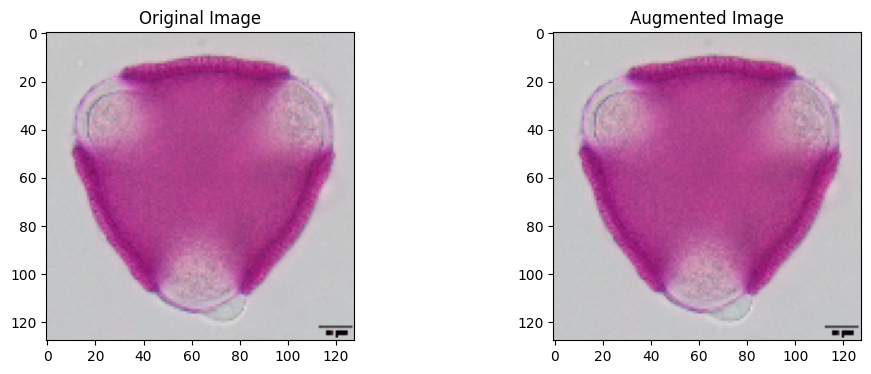

In [12]:

def plot_aug_and_org_data(real_img, augmented_img):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

  axes[0].imshow(real_img)
  axes[0].set_title("Original Image")

  axes[1].imshow(augmented_img)
  axes[1].set_title("Augmented Image")

  plt.show()
koyulacak_veri = x_train_aug[0].copy()
channel_shuffle = keras_cv.layers.ChannelShuffle()
augmented_images = channel_shuffle(koyulacak_veri)
plot_aug_and_org_data(koyulacak_veri, augmented_images)


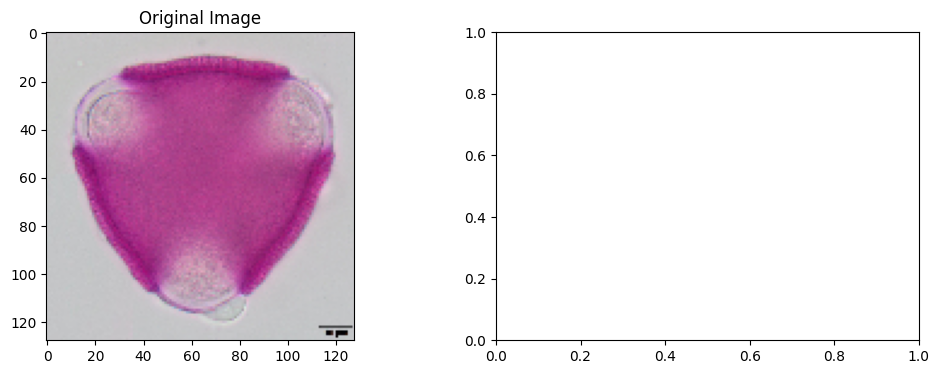

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some random data to visualize
x = x_train_aug[0].copy()

# Augment the data
#augmented_data = data_augmentation(x)

# Visualize the original and augmented data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].imshow(x)
axes[0].set_title("Original Image")



plt.show()

In [14]:
'''
Augmentation sonrasi oranlar
'''

print("oranlari train : ", len(x_train_aug) / (len(x_train_aug) + len(x_val) + len(x_test)))
print("oranlari test : ", len(x_test) / (len(x_train_aug) + len(x_val) + len(x_test)))
print("oranlari val : ", len(x_val) / (len(x_train_aug) + len(x_val) + len(x_test)))

oranlari train :  0.9627230304693933
oranlari test :  0.01800713697502059
oranlari val :  0.019269832555586057


In [15]:
# Modele sokmak için işlemler
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
y_train_aug_le = le.fit_transform(y_train_aug)
y_train_aug_cat = np_utils.to_categorical(y_train_aug_le, len(siniflar_listesi))

y_val_le  = le.fit_transform(y_val)
y_val_cat = np_utils.to_categorical(y_val_le, len(siniflar_listesi))

y_test_le  = le.fit_transform(y_test)
y_test_cat = np_utils.to_categorical(y_test_le, len(siniflar_listesi))


x_train             = np.asarray(x_train_aug).astype('float32')
x_val               = np.asarray(x_val).astype('float32')
x_test              = np.asarray(x_test).astype('float32')

y_test = np.asarray([[eleman] for eleman in y_test_le])
y_val = np.asarray([[eleman] for eleman in y_val_le])
y_train = np.asarray([[eleman] for eleman in y_train_aug_le])



In [16]:
print(type(x_train_aug))
print(type(x_test))
print(type(x_val))
print(type(x_test))

print(type(y_val_cat))
print(type(y_train_aug_cat))
print(len(x_train_aug))
print(x_train_aug[0].shape)
print(len(x_val))
print(x_val[0].shape)
print(len(x_test))
print(x_test[0].shape)

<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
17536
(128, 128, 3)
351
(128, 128, 3)
328
(128, 128, 3)


In [17]:
data_main_folder = "C:\\Users\\PC\\OneDrive\\Masaüstü\\polen-github\\Veriler\\15lihepsi"
size_folder_path = os.path.join(data_main_folder, f"{seed_degeri}")
seed_and_sized_combined_folder_path = os.path.join(size_folder_path, str(128))
if not os.path.exists(seed_and_sized_combined_folder_path):
    os.makedirs(seed_and_sized_combined_folder_path)
else:
    raise Exception("klasör var")

np.savetxt(seed_and_sized_combined_folder_path + '/y_train_aug_le.txt', y_train_aug_le)
np.savetxt(seed_and_sized_combined_folder_path + '/y_train_aug_cat.txt', y_train_aug_cat)
np.savetxt(seed_and_sized_combined_folder_path + '/y_val_le.txt', y_val_le)
np.savetxt(seed_and_sized_combined_folder_path + '/y_val_cat.txt', y_val_cat)
np.savetxt(seed_and_sized_combined_folder_path + '/y_test_le.txt', y_test_le )
np.savetxt(seed_and_sized_combined_folder_path + '/y_test_cat.txt', y_test_cat)

np.save(seed_and_sized_combined_folder_path + '/x_train', x_train)
np.save(seed_and_sized_combined_folder_path + '/x_val', x_val)
np.save(seed_and_sized_combined_folder_path + '/x_test', x_test)

np.save(seed_and_sized_combined_folder_path + '/y_test', y_test)
np.save(seed_and_sized_combined_folder_path + '/y_val', y_val)
np.save(seed_and_sized_combined_folder_path + '/y_train', y_train)